# 主题模型
- 构建主题模型
- 在主题空间比较相似度

《机器学习系统设计》第四章

## 构建主题模型

In [2]:
from __future__ import print_function
try:
    from gensim import corpora, models, matutils
except:
    print("import gensim failed.")
    print()
    print("Please install it")
    raise

import numpy as np
from os import path


# Check that data exists
if not path.exists('../data/ap/ap.dat'):
    print('Error: Expected data to be present at data/ap/')
    print('Please cd into ../data & run tar xzf ap.tgz')

# Load the data
corpus = corpora.BleiCorpus('../data/ap/ap.dat', '../data/ap/vocab.txt')

# Build the topic model
NUM_TOPICS = 100
model = models.ldamodel.LdaModel(
    corpus, num_topics=NUM_TOPICS, id2word=corpus.id2word, alpha=None)

In [5]:
# Iterate over all the topics in the model
for ti in range(model.num_topics):
    words = model.show_topic(ti, 64)
    tf = sum(float(f) for w, f in words)
    with open('tmp/topics.txt', 'w') as output:
        output.write('\n'.join('{}:{}'.format(w, int(1000. * f / tf)) for w, f in words))
        output.write("\n\n\n")

In [6]:
!head tmp/topics.txt

dresses:86
bridal:75
arts:70
grants:45
artists:33
editors:26
styles:25
fabrics:23
store:22
foundation:22


In [7]:
# We first identify the most discussed topic, i.e., the one with the
# highest total weight
topics = matutils.corpus2dense(model[corpus], num_terms=model.num_topics)
weight = topics.sum(1)
max_topic = weight.argmax()
print (max_topic)

# Get the top 64 words for this topic
# Without the argument, show_topic would return only 10 words
words = model.show_topic(max_topic, 64)
print (words)

32
[(u'i', 0.022902189263742139), (u'years', 0.0069906378987830359), (u'mrs', 0.0048900727499430318), (u'get', 0.004480703224540309), (u'time', 0.0044709541904680381), (u'frank', 0.0044655243915090589), (u'two', 0.0041386380475537379), (u'like', 0.0037109090829590789), (u'year', 0.0037005864419917146), (u'people', 0.0036874874042782187), (u'first', 0.0032958187125589726), (u'just', 0.0031885466144148116), (u'house', 0.0031331580648845296), (u'case', 0.0031242761615824619), (u'day', 0.0030418674919531863), (u'last', 0.0030335769287677399), (u'attorney', 0.0029780978887432841), (u'think', 0.0029336063218516903), (u'dont', 0.0029016982570627351), (u'committee', 0.0028621915760657199), (u'national', 0.0028041924690571773), (u'made', 0.0027305841534113868), (u'schools', 0.0027058868579118902), (u'back', 0.0026500519616374147), (u'going', 0.0025919729389822527), (u'yearold', 0.0025771921499405438), (u'student', 0.0025349985623858385), (u'job', 0.0025199081179640473), (u'percent', 0.002499371

从下图观察：大约150个文档包含了5个主题，大多数文档涵盖了10到12个主题。

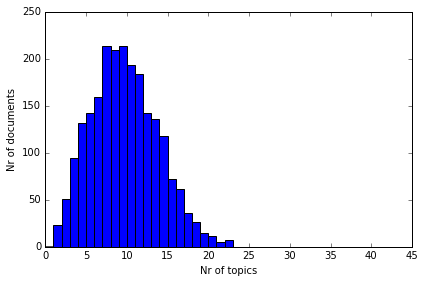

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

num_topics_used = [len(model[doc]) for doc in corpus]
fig, ax = plt.subplots()
ax.hist(num_topics_used, np.arange(42))
ax.set_ylabel('Nr of documents')
ax.set_xlabel('Nr of topics')
fig.tight_layout()

alpha值会导致每个文档包含更多的主题。

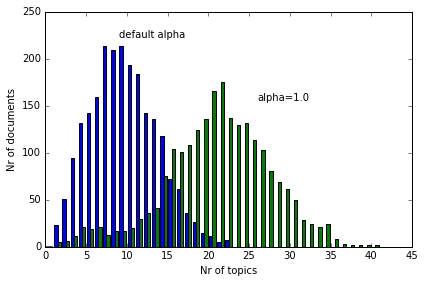

In [9]:
# Now, repeat the same exercise using alpha=1.0
# You can edit the constant below to play around with this parameter
ALPHA = 1.0

model1 = models.ldamodel.LdaModel(
    corpus, num_topics=NUM_TOPICS, id2word=corpus.id2word, alpha=ALPHA)
num_topics_used1 = [len(model1[doc]) for doc in corpus]

fig, ax = plt.subplots()
ax.hist([num_topics_used, num_topics_used1], np.arange(42))
ax.set_ylabel('Nr of documents')
ax.set_xlabel('Nr of topics')

# The coordinates below were fit by trial and error to look good
ax.text(9, 223, r'default alpha')
ax.text(26, 156, 'alpha=1.0')
fig.tight_layout()

## 在主题空间比较相似度
根据两个文档是否描述相同主题来判断它们是否相似，而不是通过词与词的比较。

In [22]:
from __future__ import print_function

try:
    import nltk.corpus
except ImportError:
    print("nltk not found")
    print("please install it")
    raise
from scipy.spatial import distance
import numpy as np
from gensim import corpora, models
import sklearn.datasets
import nltk.stem
from collections import defaultdict

english_stemmer = nltk.stem.SnowballStemmer('english')
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.update(['from:', 'subject:', 'writes:', 'writes'])


class DirectText(corpora.textcorpus.TextCorpus):

    def get_texts(self):
        return self.input

    def __len__(self):
        return len(self.input)
try:
    dataset = sklearn.datasets.load_mlcomp("20news-18828", "train",
                                       mlcomp_root='../data')
except:
    print("Newsgroup data not found.")
    print("Please download from http://mlcomp.org/datasets/379")
    print("And expand the zip into the subdirectory data/")
    print()
    print()
    raise

orig_texts = dataset.data
texts = dataset.data

texts = [t.decode('utf-8', 'ignore') for t in texts]
texts = [t.split() for t in texts]  # 分词
texts = [map(lambda w: w.lower(), t) for t in texts]  # 转小写
texts = [filter(lambda s: not len(set("+-.?!()>@012345689") & set(s)), t) for t in texts]  # 过滤得到英文单词
texts = [filter(lambda s: (len(s) > 3) and (s not in stopwords), t) for t in texts]  # 过滤stop word和短单词
texts = [map(english_stemmer.stem, t) for t in texts]  # 还原词干
usage = defaultdict(int)
for t in texts:  # t是一段文本
    for w in set(t):
        usage[w] += 1
limit = len(texts) / 10
too_common = [w for w in usage if usage[w] > limit]
too_common = set(too_common)
texts = [filter(lambda s: s not in too_common, t) for t in texts]  # 过滤出现频率过高的词

corpus = DirectText(texts)
dictionary = corpus.dictionary
try:
    dictionary['computer']
except:
    pass

model = models.ldamodel.LdaModel(corpus, num_topics=100, id2word=dictionary.id2token)

thetas = np.zeros((len(texts), 100))  # row:len(texts),col:100
for i, c in enumerate(corpus):
    for ti, v in model[c]:
        thetas[i, ti] += v

distances = distance.squareform(distance.pdist(thetas))  # sum[(ti-tj)^2]
large = distances.max() + 1
for i in range(len(distances)):  # 矩阵对角线上的元素设成较大的值,如果不设置,将会返回自己（自己和自己最相似）
    distances[i, i] = large

print(orig_texts[1])
print('+' * 100)
print(orig_texts[distances[1].argmin()])

From: geb@cs.pitt.edu (Gordon Banks)
Subject: Re: request for information on "essential tremor" and Indrol?

In article <1q1tbnINNnfn@life.ai.mit.edu> sundar@ai.mit.edu writes:

Essential tremor is a progressive hereditary tremor that gets worse
when the patient tries to use the effected member.  All limbs, vocal
cords, and head can be involved.  Inderal is a beta-blocker and
is usually effective in diminishing the tremor.  Alcohol and mysoline
are also effective, but alcohol is too toxic to use as a treatment.
-- 
----------------------------------------------------------------------------
Gordon Banks  N3JXP      | "Skepticism is the chastity of the intellect, and
geb@cadre.dsl.pitt.edu   |  it is shameful to surrender it too soon." 
----------------------------------------------------------------------------

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
From: rgc3679@bcstec.ca.boeing.com (Robert G. Carpenter)
Subject: Please Re